## LRP

Biblioteki:\
pip install tf2onnx onnx onnx2pytorch zennit

Używana wersja Python'a: 3.12.8

In [36]:
# Biblioteki

import tensorflow as tf
import tf2onnx
from onnx2pytorch import ConvertModel
import onnx

from PIL import Image
import torchvision.transforms as transforms
import torch

from zennit.rules import Epsilon
from zennit.composites import EpsilonPlusFlat
from zennit.attribution import Gradient

import matplotlib.pyplot as plt
import numpy as np


In [37]:
# Constants

IMG_WIDTH=128
IMG_HEIGHT=128
TEST_IMG_PATH = "./data/dogs-vs-cats/test1/"

### Tensorflow -> PyTorch

Przekształcamy model TensorFlow na model Pytorch'a aby skorzystać z biblioteki Zennit do metody LRP

In [38]:
# .h5 -> .onnx
model = tf.keras.models.load_model("cats_dogs_cnn.h5")
model.output_names = ['output']

onnx_model_path = "cats_dogs_cnn.onnx"
spec = [tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype, name='digit')]
onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13)


with open(onnx_model_path, "wb") as f:
    f.write(onnx_model.SerializeToString())

print("ONNX model:", onnx_model_path)

ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x000001E67330E8E0>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.


ONNX model: cats_dogs_cnn.onnx


In [39]:
# Ładujemy model do PyTorcha aby skorzystać z biblioteki Zennit

onnx_model = onnx.load(onnx_model_path)

pytorch_model = ConvertModel(onnx_model)

print(pytorch_model)


ConvertModel(
  (Transpose_sequential_3_1/conv2d_15_1/BiasAdd__252:0): Transpose()
  (Conv_sequential_3_1/conv2d_15_1/BiasAdd:0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (Relu_sequential_3_1/conv2d_15_1/Relu:0): ReLU(inplace=True)
  (Mul_sequential_3_1/batch_normalization_15_1/batchnorm/mul_1:0): mul()
  (Add_sequential_3_1/batch_normalization_15_1/batchnorm/add_1:0): Add()
  (MaxPool_sequential_3_1/max_pooling2d_15_1/MaxPool2d:0): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (Conv_sequential_3_1/conv2d_16_1/BiasAdd:0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (Relu_sequential_3_1/conv2d_16_1/Relu:0): ReLU(inplace=True)
  (Mul_sequential_3_1/batch_normalization_16_1/batchnorm/mul_1:0): mul()
  (Add_sequential_3_1/batch_normalization_16_1/batchnorm/add_1:0): Add()
  (MaxPool_sequential_3_1/max_pooling2d_16_1/MaxPool2d:0): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (Conv_sequential

### Image Preprocessing

In [40]:

image_path = TEST_IMG_PATH + "1.jpg"

def prepare_image(image_path):

    image = Image.open(image_path).convert("RGB")

    transform = transforms.Compose([
        transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
        transforms.ToTensor(),
    ])

    input_image = transform(image).unsqueeze(0)
    input_image = input_image.permute(0, 2, 3, 1)  # convert to (1, 128, 128, 3) Tensorflor > PyTorch formats


    print("Input image shape:", input_image.shape)  # [1, 128, 128, 3]
    return input_image

input_image = prepare_image(image_path)


Input image shape: torch.Size([1, 128, 128, 3])


### PyTorch model verification

In [41]:
# Sprawdzenie czy model PyTorch-owy został poprawnie załadowany
pytorch_model.eval()

ConvertModel(
  (Transpose_sequential_3_1/conv2d_15_1/BiasAdd__252:0): Transpose()
  (Conv_sequential_3_1/conv2d_15_1/BiasAdd:0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (Relu_sequential_3_1/conv2d_15_1/Relu:0): ReLU(inplace=True)
  (Mul_sequential_3_1/batch_normalization_15_1/batchnorm/mul_1:0): mul()
  (Add_sequential_3_1/batch_normalization_15_1/batchnorm/add_1:0): Add()
  (MaxPool_sequential_3_1/max_pooling2d_15_1/MaxPool2d:0): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (Conv_sequential_3_1/conv2d_16_1/BiasAdd:0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (Relu_sequential_3_1/conv2d_16_1/Relu:0): ReLU(inplace=True)
  (Mul_sequential_3_1/batch_normalization_16_1/batchnorm/mul_1:0): mul()
  (Add_sequential_3_1/batch_normalization_16_1/batchnorm/add_1:0): Add()
  (MaxPool_sequential_3_1/max_pooling2d_16_1/MaxPool2d:0): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (Conv_sequential

In [42]:
# Sprawdzenie działania modelu na przykładowym obrazie

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pytorch_model.to(device)
input_image = input_image.to(device)


with torch.no_grad():
    output = pytorch_model(input_image)

probability = torch.sigmoid(output).item()

prediction = "Dog" if probability > 0.5 else "Cat"

print(f"Prediction: {prediction} (Probability: {probability:.4f})")


Prediction: Dog (Probability: 0.7246)


### LRP

In [43]:
# Metoda LRP

def LRP_method(pytorch_model, input_image):

    pytorch_model.eval()

    # LRP:
    composite = EpsilonPlusFlat(epsilon=1e-6)

    with Gradient(pytorch_model, composite=composite) as attributor:
        _, relevance = attributor(input_image)

    relevance = relevance.detach().cpu().numpy()

    print("Relevance shape:", relevance.shape)  # [1, 128, 128, 3]
    return relevance

def plot_lrp(image, heatmap):
    _, axes = plt.subplots(1, 2, figsize=(10, 5))

    orig_image = image.squeeze().numpy()
    axes[0].imshow(orig_image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    heatmap_2d = np.sum(heatmap.squeeze(), axis=-1)  #  (1,128,128,3) > (128,128)

    axes[1].imshow(heatmap_2d, cmap="seismic", interpolation="nearest")
    axes[1].set_title("LRP Heatmap")
    axes[1].axis("off")

    plt.show()



Relevance shape: (1, 128, 128, 3)


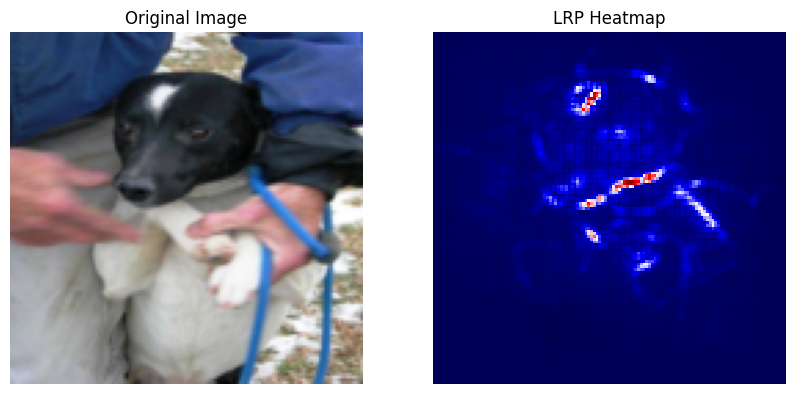

In [44]:
relevance = LRP_method(pytorch_model, input_image)

plot_lrp(input_image, relevance)
